# Genetic Algorithm Feature Selection for Football Match Prediction
This notebook implements a genetic algorithm to select the best features for predicting football match outcomes using a neural network model. The model is trained and evaluated on the selected features.

In [321]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import pygad
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from codecarbon import EmissionsTracker
import logging

The architecture of the neural network is the same as the one used in the prediction_model.ipynb notebook

In [322]:
class RegularizedFootballModel(nn.Module):
    def __init__(self, input_features):
        super().__init__()
        
        self.network = nn.Sequential(
            # First block
            nn.Linear(input_features, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            # Second block
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            # Third block
            nn.Linear(64, 32),
            nn.ReLU(),
            
            # Output layer
            nn.Linear(32, 1)
        )
        
        for layer in self.network:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.zeros_(layer.bias)
        
    def forward(self, x):
        return self.network(x)

```load_data``` function loads the normalized football match dataset, fills missing values, selects predictive features, and splits the data into training, validation and test sets

In [323]:
def load_data():
    df = pd.read_csv('data/normalized/normalized_matches_df.csv')
    df.fillna(df.mean(), inplace=True)
    
    # Feature selection
    predictive_features = [
        'HT_Form', 'AT_Form',
        'HT_W_Odds', 'Draw_Odds', 'AT_W_Odds',
        '5GAV_FT_HT_Goals', '5GAV_FT_AT_Goals',
        '5GAV_HT_Shots', '5GAV_AT_Shots',
        '5GAV_HT_Shots_target', '5GAV_AT_Shots_target',
        '5GAV_HT_Corners', '5GAV_AT_Corners',
        'AVG_Influence_HT', 'AVG_ICT_Index_HT',
        'AVG_Influence_AT', 'AVG_ICT_Index_AT',
        'Injured_Players_HT', 'Injured_Players_AT',
        'HT_Players_Performances', 'AT_Players_Performances'
    ]
    
    X = df[predictive_features]
    y = df["FT_Result_code"]  # Target variable: 1 if home team wins, 0 otherwise
    
    # Convert to PyTorch tensors
    X_tensor = torch.tensor(X.values, dtype=torch.float32)
    y_tensor = torch.tensor(y.values, dtype=torch.float32)


    X_temp, X_test, y_temp, y_test = train_test_split(X_tensor, y_tensor, test_size=0.1, random_state=42)

    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=1/9, random_state=42
    )


    print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

    print(f"Feature dimensions: {X_train.shape[1]}")
    return X_train, X_val, X_test, y_train, y_val, y_test, predictive_features



Helper functions to create models with selected features and to train and evaluate models

In [324]:
def create_model_with_selected_features(selected_features_mask, device):
    num_selected_features = np.sum(selected_features_mask)
    model = RegularizedFootballModel(num_selected_features).to(device)
    return model

def train_model(model, X_train, y_train, X_test, y_test, device, epochs=100):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.BCEWithLogitsLoss()

    X_train = X_train.to(device)
    y_train = y_train.to(device)
    X_test = X_test.to(device)
    y_test = y_test.to(device)
    
    # Training loop
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = loss_fn(y_pred.squeeze(), y_train)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
    
    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
        y_pred_binary = (torch.sigmoid(y_pred.squeeze()) > 0.5).float()
        accuracy = (y_pred_binary == y_test).float().mean().item()
    
    return accuracy

Defines the fitness function for the genetic algorithm. Each individual represents a subset of features, and the fitness is the model's accuracy using those features.

In [325]:
def fitness_function(ga_instance, solution, solution_idx):
    feature_mask = solution.astype(bool)

    if not np.any(feature_mask):
        return 0

    # Use validation data for evaluation
    X_train_selected = X_train[:, feature_mask]
    X_val_selected = X_val[:, feature_mask]

    model = create_model_with_selected_features(feature_mask, device)
    accuracy = train_model(model, X_train_selected, y_train, X_val_selected, y_val, device)

    return accuracy


```run_genetic_algorithm``` function configures and runs the genetic algorithm to search for the optimal subset of features.

In [326]:
def run_genetic_algorithm(X_train, X_val, X_test, y_train, y_val, y_test, predictive_features, device):
    num_features = X_train.shape[1]

    # GA parameters
    num_generations = 30
    num_parents_mating = 10
    sol_per_pop = 20
    num_genes = num_features
    mutation_probability = 0.1

    # Create the GA instance
    ga_instance = pygad.GA(
        num_generations=num_generations,
        num_parents_mating=num_parents_mating,
        sol_per_pop=sol_per_pop,
        num_genes=num_genes,
        fitness_func=fitness_function,
        gene_type=int,
        gene_space=[0, 1],  # Binary encoding for feature selection
        mutation_probability=mutation_probability,
        crossover_type="single_point",
        mutation_type="random",
        keep_parents=1
    )

    # Run the genetic algorithm
    ga_instance.run()

    # Get the best solution
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    plt.figure(figsize=(10, 6))
    plt.plot(ga_instance.best_solutions_fitness)
    plt.title("Fitness Evolution")
    plt.xlabel("Generation")
    plt.ylabel("Fitness (Accuracy)")
    plt.grid(True)
    plt.savefig("plots/genetic_algorithm_fitness_evolution.png")
    plt.close()

    solution_mask = solution.astype(bool)
    selected_feature_names = [feature for feature, mask in zip(predictive_features, solution_mask) if mask]
    return solution_mask, selected_feature_names

After selecting the best features, we retrain the model and visualize its performance.

In [327]:
def train_final_model(selected_features_mask, X_train, y_train, X_val, y_val, X_test, y_test, device):
    # Select features for all datasets
    X_train_final = X_train[:, selected_features_mask]
    X_val_final = X_val[:, selected_features_mask]
    X_test_final = X_test[:, selected_features_mask]

    # Create model and move to device
    final_model = create_model_with_selected_features(selected_features_mask, device)
    optimizer = torch.optim.Adam(final_model.parameters(), lr=0.001)
    loss_fn = nn.BCEWithLogitsLoss()

    X_train_final = X_train_final.to(device)
    y_train = y_train.to(device)
    X_val_final = X_val_final.to(device)
    y_val = y_val.to(device)
    X_test_final = X_test_final.to(device)
    y_test = y_test.to(device)

    # Track validation metrics
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    epochs = 100
    for epoch in range(epochs):
        # Training phase
        final_model.train()
        y_logits = final_model(X_train_final)
        y_pred = torch.round(torch.sigmoid(y_logits.squeeze()))
        loss = loss_fn(y_logits.squeeze(), y_train)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(final_model.parameters(), max_norm=1.0)
        optimizer.step()

        # Calculate training accuracy
        acc = (y_pred == y_train).float().mean().item() * 100

        # Validation phase
        final_model.eval()
        with torch.no_grad():
            val_logits = final_model(X_val_final)
            val_pred = torch.round(torch.sigmoid(val_logits.squeeze()))
            val_loss = loss_fn(val_logits.squeeze(), y_val)
            val_acc = (val_pred == y_val).float().mean().item() * 100

        # Update metrics
        train_losses.append(loss.item())
        val_losses.append(val_loss.item())
        train_accuracies.append(acc)
        val_accuracies.append(val_acc)

        if epoch % 10 == 0 or epoch == epochs - 1:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Train acc: {acc:.2f}% | "
                  f"Val loss: {val_loss:.5f}, Val acc: {val_acc:.2f}%")

    # Final test evaluation
    final_model.eval()
    with torch.no_grad():
        test_logits = final_model(X_test_final)
        test_pred = torch.round(torch.sigmoid(test_logits.squeeze()))
        test_loss = loss_fn(test_logits.squeeze(), y_test)
        test_acc = (test_pred == y_test).float().mean().item() * 100


    # Plotting
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracies, label="Train accuracy", color="#6E0096")
    plt.plot(val_accuracies, label="Validation accuracy", color="#FFA600")
    plt.title("Accuracy Curves")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label="Train loss", color="#6E0096")
    plt.plot(val_losses, label="Validation loss", color="#FFA600")
    plt.title("Loss Curves")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

    torch.save(final_model.state_dict(), "models/genetic_optimized_model.pth")


    return {
        'model': final_model,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'test_accuracy': test_acc
    }


Now execute the entire pipeline: load data, run genetic algorithm for feature selection, retrain with selected features, and compare results.

[codecarbon WARNING @ 11:35:51] Multiple instances of codecarbon are allowed to run at the same time.


Train: 2258, Val: 283, Test: 283
Feature dimensions: 21
Epoch: 0 | Loss: 0.70027, Train acc: 46.06% | Val loss: 0.69718, Val acc: 43.82%
Epoch: 10 | Loss: 0.67514, Train acc: 55.54% | Val loss: 0.67120, Val acc: 56.18%
Epoch: 20 | Loss: 0.65754, Train acc: 62.75% | Val loss: 0.65145, Val acc: 65.37%
Epoch: 30 | Loss: 0.63367, Train acc: 64.53% | Val loss: 0.62866, Val acc: 66.08%
Epoch: 40 | Loss: 0.62054, Train acc: 64.53% | Val loss: 0.60989, Val acc: 67.14%
Epoch: 50 | Loss: 0.61002, Train acc: 65.77% | Val loss: 0.59822, Val acc: 68.90%
Epoch: 60 | Loss: 0.59907, Train acc: 66.78% | Val loss: 0.59231, Val acc: 71.73%
Epoch: 70 | Loss: 0.59917, Train acc: 66.74% | Val loss: 0.59012, Val acc: 70.67%
Epoch: 80 | Loss: 0.59467, Train acc: 67.49% | Val loss: 0.58981, Val acc: 69.96%
Epoch: 90 | Loss: 0.58647, Train acc: 68.64% | Val loss: 0.59017, Val acc: 70.32%
Epoch: 99 | Loss: 0.58925, Train acc: 69.00% | Val loss: 0.59040, Val acc: 70.32%


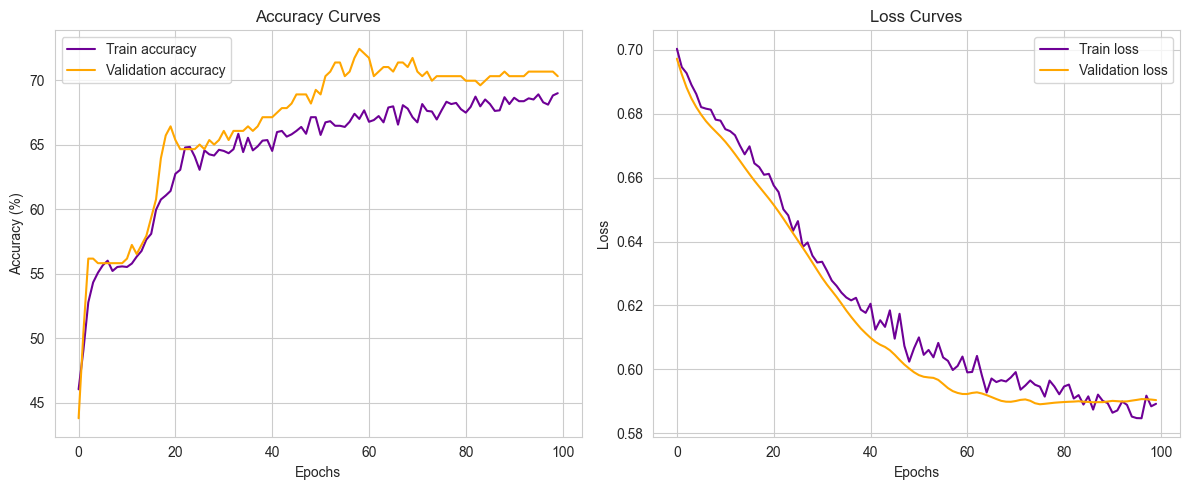

Final test accuracy: 71.02%
CO₂ emissions (kg): 0.001532
Number of original features: 21
Number of selected features: 12
Selected features:
- AT_Form
- HT_W_Odds
- Draw_Odds
- AT_W_Odds
- 5GAV_FT_HT_Goals
- 5GAV_HT_Shots_target
- 5GAV_AT_Corners
- AVG_Influence_HT
- AVG_ICT_Index_HT
- Injured_Players_AT
- HT_Players_Performances
- AT_Players_Performances


In [328]:
logging.getLogger("codecarbon").setLevel(logging.WARNING)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train, X_val, X_test, y_train, y_val, y_test, predictive_features = load_data()

final_test_accuracy = 0
attempt = 1

# Start CO2 emissions tracking
tracker = EmissionsTracker(output_dir="codecarbon_logs", measure_power_secs=1,log_level="error")
tracker.start()


selected_features_mask, selected_feature_names = run_genetic_algorithm(
    X_train, X_val, X_test, y_train, y_val, y_test, predictive_features, device
)

final_results = train_final_model(
    selected_features_mask,
    X_train, y_train,
    X_val, y_val,
    X_test, y_test,
    device
)

final_test_accuracy = final_results['test_accuracy']
final_model = final_results['model']
final_val_accuracy = final_results['val_accuracies'][-1]


# Stop CO2 emissions tracking
emissions: float = tracker.stop()

print(f"Final test accuracy: {final_test_accuracy:.2f}%")
print(f"CO₂ emissions (kg): {emissions:.6f}")
print(f"Number of original features: {len(predictive_features)}")
print(f"Number of selected features: {np.sum(selected_features_mask)}")
print("Selected features:")
for feature in selected_feature_names:
    print(f"- {feature}")

torch.save(final_model.state_dict(), "models/genetic_optimized_model.pth")
